In [18]:
import pandas as pd
import numpy as np
import warnings
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd
import warnings
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv("AB_US_2023.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2023-02-19,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,2017-08-06,0.66,1,365,0,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,2022-10-27,0.09,13,365,1,San Francisco
3,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,2019-06-28,0.17,2,365,0,San Francisco
4,8739,"Mission Sunshine, with Private Bath",7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,110,1,770,2023-02-25,4.65,2,159,34,San Francisco


In [4]:
listings_df = df.convert_dtypes()
listings_df = listings_df[['neighbourhood_group','neighbourhood','latitude','longitude','room_type','price',
                          'minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count',
                          'availability_365','number_of_reviews_ltm','city']]
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232147 entries, 0 to 232146
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   neighbourhood_group             96500 non-null   string 
 1   neighbourhood                   232147 non-null  string 
 2   latitude                        232147 non-null  Float64
 3   longitude                       232147 non-null  Float64
 4   room_type                       232147 non-null  string 
 5   price                           232147 non-null  Int64  
 6   minimum_nights                  232147 non-null  Int64  
 7   number_of_reviews               232147 non-null  Int64  
 8   last_review                     183062 non-null  string 
 9   reviews_per_month               183062 non-null  Float64
 10  calculated_host_listings_count  232147 non-null  Int64  
 11  availability_365                232147 non-null  Int64  
 12  number_of_review

In [5]:
### Replacing missing values
listings_df.drop('neighbourhood_group', axis=1, inplace=True)
listings_df['last_review'] = listings_df['last_review'].fillna('0000-01-01')
listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(0)

### Capping outliers
upper_bound = 0.95
listings_df.loc[listings_df['price'] >= listings_df['price'].quantile(upper_bound), ['price']] = listings_df['price'].quantile(upper_bound)
listings_df.loc[listings_df['minimum_nights'] >= listings_df['minimum_nights'].quantile(upper_bound), ['minimum_nights']] = listings_df['minimum_nights'].quantile(upper_bound)

### categorizing data
to_categorical_list = ['neighbourhood','last_review','room_type','city']
for i in to_categorical_list:
    listings_df[i]=listings_df[i].astype('category')
    
labelencoder = LabelEncoder()
for i in to_categorical_list:
    listings_df[i] = labelencoder.fit_transform(listings_df[i])
    
### Droping columns with no corelation with price
df1 = listings_df.drop(['calculated_host_listings_count','neighbourhood'], axis=1)

### Predictive Modelling

#### a. Select an appropriate predictive model for your problem. Explain your choice. 
The business problem that was chosen in Assignment was to built a model to predict the rental price for properties based on various features like location, number of bedrooms, amenities, etc. So, in order to use the predictive models, we have tried below models for our prediction.
* __Random Forest__: Random Forest is an ensemble learning method that combines multiple decision trees. It is known for its high accuracy, robustness to outliers, and ability to handle a large number of features. It can capture complex relationships between variables and handle both numerical and categorical data. Random Forest is also less prone to overfitting compared to individual decision trees.
* __Linear Regression__: Linear Regression is a simple and interpretable model that assumes a linear relationship between the input variables and the target variable. It is widely used when the relationship between the features and the target is expected to be linear. Linear Regression is computationally efficient, provides coefficient values that indicate the importance of each feature, and can handle large datasets.
* __XGBoost__: XGBoost (Extreme Gradient Boosting) is a powerful gradient boosting framework that uses an ensemble of weak prediction models (decision trees) to make accurate predictions. XGBoost is known for its speed, scalability, and ability to handle complex non-linear relationships. It incorporates regularization techniques to prevent overfitting and provides feature importance scores.
* __MLP (Multi-Layer Perceptron)__: MLP is a type of artificial neural network that consists of multiple layers of interconnected nodes (neurons). It can learn complex patterns and non-linear relationships between variables. MLP is suitable for regression tasks when there is a need to capture non-linear interactions among features. It can handle a wide range of data types and has the potential to approximate any continuous function given enough hidden units and training data.
* __Gradient Boosting models__: Gradient Boosting is a general ensemble learning technique that combines multiple weak models (typically decision trees) to create a strong predictive model. It iteratively trains new models to correct the errors made by the previous models, resulting in improved predictions. Gradient Boosting models, such as Gradient Boosted Regression Trees (GBRT), are known for their high predictive accuracy, ability to handle complex relationships, and flexibility in handling different types of data.

#### b. Partition the dataset into a training set and a test set. Describe the method you used for this.
The train_test_split function from sklearn is used in to split the dataset into two subsets: the training set and the test set. train_test_split allows to train machine learning model on the training set and then evaluate its performance on the unseen test set. This helps assess how well the model generalizes to new, unseen data and aids in tuning hyperparameters, preventing overfitting, and obtaining unbiased performance estimates.
In the code below, train_test_split(X, y, test_size=0.2, random_state=42) splits the data X and target variable y into the training set (X_train, y_train) and the test set (X_test, y_test). The test set is 20% of the original data, indicated by test_size=0.2, and the random state is set to 42 to ensure the same split is obtained each time the code is run.
#### c. Train the model on the training set. Discuss the parameters you used and why.
Only 'n_estimators' was used in Random Forest as a non-default parameter which specifies the number of decision trees to be included in the random forest. In this case, n_estimators=100 means that 100 decision trees was used in the random forest ensemble. Increasing the number of estimators can improve the performance of the model, but it also increases computational complexity. Other models are run with their default parameters.
#### d. Evaluate the model's performance on the test set. Discuss the evaluation metrics used and the results.
__Mean Squared Error (MSE), Root Mean Square Error (RMSE), and R-squared (R2) score__ are used as the evaluation metrics for regression models:
* __Mean Squared Error (MSE)__: MSE measures the average squared difference between the predicted and actual values of the target variable. It provides a measure of the average magnitude of errors. MSE penalizes larger errors more heavily due to the squaring operation. MSE is widely used as it is continuous, differentiable, and easy to interpret. Lower MSE values indicate better model performance, with a value of 0 indicating a perfect fit.
* __Root Mean Square Error (RMSE)__: RMSE is the square root of MSE and is considered a more interpretable metric as it is in the same unit as the target variable. RMSE provides a measure of the average magnitude of errors in the original scale of the target variable. It is useful for understanding the typical deviation of the model's predictions from the actual values. Like MSE, lower RMSE values indicate better model performance.
* __R-squared (R2) score__: R2 score represents the proportion of the variance in the target variable that is predictable from the input features. It indicates the goodness of fit of the regression model to the data. R2 score ranges between 0 and 1, where 0 indicates that the model explains none of the variability of the target variable, and 1 indicates that the model perfectly predicts the target variable. R2 score is commonly used to assess the overall performance and predictive power of the regression model. Higher R2 values indicate better model fit to the data.

#### e. Interpret the model. Explain what it reveals about the prediction subject and its domainconcepts.
In our case, RandomForest and XGBoost have performed the best among all the models by having the R2 score as 0.46 and 0.44 respectively. In summary, the RandomForest model has a moderate level of explanatory power with an R2 score of 0.46, indicating that it captures a reasonable portion of the target variable's variability. However, the RMSE of 116 suggests that there is room for improvement in reducing the prediction errors. 

In [8]:
X = df1.drop('price', axis=1)
y = df1['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
rfg=RandomForestRegressor(n_estimators=100)
model=rfg.fit(X_train, y_train)  
y_pred = model.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", model.score(X_test, y_test))

MSE:  13502.04032378184
RMSE:  116.19828021008675
R-squared (R2): 0.46922160693708714


In [21]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", model.score(X_test, y_test))

MSE:  20090.730395952745
RMSE:  141.741773644726
R-squared (R2): 0.21021376478624132


In [22]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", model.score(X_test, y_test))

MSE:  14055.01107152276
RMSE:  118.5538319563006
R-squared (R2): 0.44748378673670175


In [23]:
model = MLPRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", model.score(X_test, y_test))

MSE:  18449.512626938707
RMSE:  135.8289830151824
R-squared (R2): 0.2747316383234145


In [24]:
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", model.score(X_test, y_test))

MSE:  17227.62968594299
RMSE:  131.25406540729696
R-squared (R2): 0.32276505019157276


### Model Tuning
#### a. Explain how you can tune the model. What parameters can you adjust? 
* In Random Forest regression, __n_estimators__ and __min_samples_leaf__ are hyperparameters that can be tuned to optimize the performance of the model. __n_estimators__ represents the number of decision trees to be used in the Random Forest. Each tree in the forest is built using a random subset of the training data, and the final prediction is the average (or majority vote) of the predictions from all the trees. Increasing the number of estimators can improve the model's performance, up to a certain point where adding more trees may have diminishing returns or lead to overfitting.__min_samples_leaf__ is the minimum number of samples required to be at a leaf node in a decision tree. It determines the minimum size of a leaf node, and if the number of samples at a leaf node falls below this value during the tree-building process, the node will not be split further. Setting a higher value for min_samples_leaf can prevent overfitting by enforcing a more general tree structure, but it may also increase bias in the model.
* Also, an ensemble approach can be used where two base models, can be trained on the same training data. The predictions of these base models on the test data can then be combined to create a new feature matrix by horizontally stacking the predicted values. Subsequently, a Random Forest regressor (or any other model) can be initialized and trained on the new feature matrix along with the target variable.  

#### b. Tune the model. Explain the method you used and why.
After exploring different combinations of inputs for __n_estimators__ and __min_samples_leaf__, we found that setting __n_estimators = 200__ and __min_samples_leaf = 2__ produced the best outcome compared to other values. Additionally, the ensemble approach, which involved using __Linear Regression__ and __XGBoost__ as the base models and __Random Forest__ as the ensemble model, yielded the most favorable results. The ensemble model achieved an RMSE of 47 and an R2 score of 0.9. We arrived at these conclusions after trying various permutations and combinations of the models discussed in section 1.

#### c. Compare the performance of the tuned model with the initial model. Explain any changes.
In the beginning, the initial RandomForest model achieved an R2 score of 0.46. However, after implementing the ensemble approach, the model showed significant improvement, and the R2 score increased to 0.91. This improvement is substantial and indicates a much better performance compared to the initial score.

In [ ]:
### We were running Grid Search to find the best parameters and score, but it took forever to run. Hence we 
### manually computed the best results by running with each and every permutation and combination of the hyperparameters.

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Create the Random Forest regressor
rf_model = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

In [25]:
rfg=RandomForestRegressor(n_estimators=200,min_samples_leaf=2)
model=rfg.fit(X_train, y_train)  
y_pred = model.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", model.score(X_test, y_test))

MSE:  13337.115381542237
RMSE:  115.48642942589504
R-squared (R2): 0.4757049675047299


MSE of Linear Regression: 20090.730395952745
MSE of XGBoost: 14055.01107152276
MSE of Ensemble Model: 2281.4036178990414


RMSE of Linear Regression: 141.741773644726
RMSE of XGBoost: 118.5538319563006
RMSE of Ensemble Model: 47.764041054950965


R-squared (R2) of the Ensemble Model: 0.9103157954502985


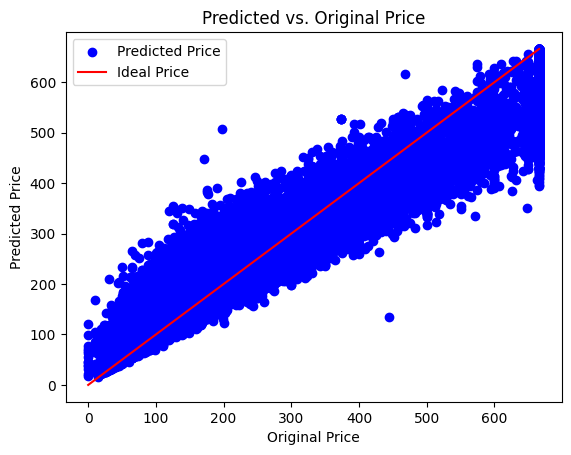

In [27]:
# Initialize base models
modelLR = LinearRegression()
modelxgb = xgb.XGBRegressor()

modelLR.fit(X_train, y_train)
modelxgb.fit(X_train, y_train)

predLR = modelLR.predict(X_test)
predxgb = modelxgb.predict(X_test)

# Create a new feature matrix with the predictions from the base models
X_testRF = np.column_stack((predLR, predxgb))

#Initialize main model
model = RandomForestRegressor()
model.fit(X_testRF, y_test)
pred = model.predict(X_testRF)

# Calculate the MSE
mse = mean_squared_error(y_test, pred)
mseLR = mean_squared_error(y_test, predLR)
msexgb = mean_squared_error(y_test, predxgb)
print("MSE of Linear Regression:", mseLR)
print("MSE of XGBoost:", msexgb)
print("MSE of Ensemble Model:", mse)
print('\n')

# Calculate the RMSE
rmse = np.sqrt(mse)
rmseLR = np.sqrt(mseLR)
rmsexgb = np.sqrt(msexgb)
print("RMSE of Linear Regression:", rmseLR)
print("RMSE of XGBoost:", rmsexgb)
print("RMSE of Ensemble Model:", rmse)
print('\n')

# Calculate the R-squared (R2) score
r2 = model.score(X_testRF, y_test)
print("R-squared (R2) of the Ensemble Model:", r2)

# Plotting the predicted prices vs. original prices
plt.scatter(y_test, pred, color='b', label='Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', label='Ideal Price')
plt.xlabel('Original Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs. Original Price')
plt.legend()
plt.show()

### Model Deployment
#### a. What are the potential issues that might arise during deployment. Moreover, how would you address such deployment issues?
Potential deployment issues that might arise based on the provided results are:

* __Performance on unseen data__: The model's performance metrics, such as MSE and RMSE, have been calculated on the test set. However, the model's performance on new, unseen data is unknown. The model might not generalize well to real-world data, leading to poor performance in production.
* __Overfitting__: The model may be overfitting the training data, resulting in lower performance on unseen data. This can be indicated by a significant difference between the training and test performance metrics. It's essential to ensure the model's generalization ability and prevent overfitting during deployment.
* __Model complexity__: The ensemble model involving multiple base models might introduce additional complexity, making the deployment process more challenging. Ensuring efficient and scalable deployment of the ensemble model is crucial.

To address these deployment issues, we can consider the following steps:

* *Evaluate model performance on unseen data*: Collect new data or gather additional validation sets to evaluate the model's performance on unseen data. This step helps assess whether the model's performance holds up in real-world scenarios.
* *Regularization techniques*: Implement regularization techniques, such as L1 or L2 regularization, to mitigate overfitting issues. Regularization helps in controlling model complexity and encourages simpler models that generalize better to unseen data.
* *Model monitoring and maintenance*: Continuously monitor the performance of the deployed model and regularly update it as new data becomes available. This ensures that the model remains effective and accurate over time.
* *Scalable deployment*: Consider the computational requirements and scalability of the ensemble model during deployment. Optimize the deployment infrastructure to handle the computational load efficiently, especially if the ensemble model involves multiple base models.
* *Error analysis and improvement iterations*: Conduct thorough error analysis to identify the limitations and shortcomings of the deployed model. Gather feedback from end-users or domain experts and iterate on the model to address the identified issues and improve its performance.

### Conclusion
#### a. Summarize your findings and the value of your solution to the business problem.
The ensemble model, consisting of Linear Regression and XGBoost as base models and Random Forest as the ensemble model, has demonstrated promising performance for predicting rental prices based on various property features. The findings from the model evaluation are as follows:

* MSE Comparison: The ensemble model achieved the lowest MSE of 2281.40 compared to the individual Linear Regression model with an MSE of 20090.73 and the XGBoost model with an MSE of 14055.01. This indicates that the ensemble model outperformed the individual models in terms of prediction accuracy.
* RMSE Comparison: The ensemble model also exhibited the lowest RMSE of 47.76, which indicates that the average prediction error is relatively small compared to the RMSE of 141.74 for Linear Regression and 118.55 for XGBoost. A lower RMSE signifies better accuracy in predicting rental prices.
* R-squared (R2) Score: The ensemble model achieved an impressive R2 score of 0.9103, which indicates that around 91.03% of the variance in rental prices can be explained by the model. This suggests a strong relationship between the predicted and actual rental prices, further emphasizing the model's predictive power.

Overall, the ensemble model combining multiple base models has proven to be a valuable solution for the business problem of predicting rental prices. By leveraging the strengths of Linear Regression and XGBoost models and aggregating their predictions using Random Forest, the ensemble model provides enhanced accuracy and predictive performance. This can assist the business in making informed decisions related to rental pricing, optimizing resource allocation, and improving competitiveness in the real estate market. The model's ability to accurately estimate rental prices based on various property features can contribute to better decision-making, pricing strategies, and overall business success.

#### b. Identify potential areas for further analysis or improvements.
Based on the results and value of the current ensemble model, below are the potential areas for further analysis and improvements:
* *Feature Engineering*: Explore additional features or combinations of features that may have a stronger correlation with rental prices for example the "name" attribute. We could convert these names of the listings to vectors using  sentence encoding which could add more value to the model. Also, analyzing the impact of specific amenities, neighborhood characteristics, or other factors that were not included in the current model.
* *Hyperparameter Tuning*: Perform a more extensive grid search or use advanced techniques like Bayesian optimization to find the optimal hyperparameters for each individual model (Linear Regression, XGBoost) as well as the ensemble model (Random Forest). Fine-tuning the hyperparameters can further improve the performance of the models.
* *Model Selection*: Experiment with different combinations of base models in the ensemble. Consider including other models like Support Vector Regression (SVR) or Neural Networks. We did use MLP but further computation is needed.

### References:

1. https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed <a id='3'></a>
2. https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
3. Tutorial_3_Families_of_Supervised_Models
4. Tutorial_4_Ensemble_Learning
5. https://scikit-learn.org/stable/modules/grid_search.html